### Import Libraries and TensforFlow Setup

In [21]:
import numpy as np
import pandas as pd
import os, glob, shutil, pickle, random, gc
from collections import Counter
from PIL import Image
from sklearn.utils import shuffle
from sklearn.model_selection import KFold

import tensorflow as tf
from keras import models, layers, optimizers
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import Model

from tensorflow.keras.experimental import CosineDecay
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import (Dense, Dropout, Activation, Input, 
                                     GlobalAveragePooling2D, average, add, 
                                     maximum)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [3]:
seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, 
                                        inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), 
                            config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

### Import Data

Data is available on Kaggle: https://www.kaggle.com/c/cassava-leaf-disease-classification/data

In [4]:
# Defining the working directories
work_dir = 'cassava-leaf-disease-classification/'
train_path = 'cassava-leaf-disease-classification/train_images/'

### Determine labels of diseases

In [5]:
mapping = pd.read_json(work_dir + 'label_num_to_disease_map.json', 
                       lines=True).transpose()[0].to_dict()

mapping

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

In [6]:
df = pd.read_csv(work_dir + '/train.csv')
df = shuffle(df, random_state=42)
df["filepath"] = train_path+df["image_id"]
df.head()

image_id  label  \
9134   2615227158.jpg      4   
1580   1277648239.jpg      3   
7304   2305895487.jpg      3   
13196   336299725.jpg      2   
5333   1951270318.jpg      2   

                                                filepath  
9134   cassava-leaf-disease-classification/train_imag...  
1580   cassava-leaf-disease-classification/train_imag...  
7304   cassava-leaf-disease-classification/train_imag...  
13196  cassava-leaf-disease-classification/train_imag...  
5333   cassava-leaf-disease-classification/train_imag...

### EDA

The model is not balanced with CMD (Cassava Mosaic Disease) being the most common label. CMD label contains 13,000 images which is five times than the average amount of images from the rest of the labels.

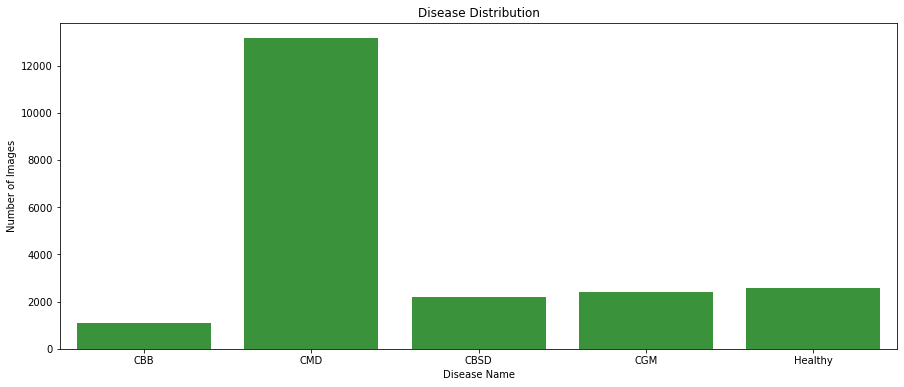

In [18]:
input_dir = '/mnt/processed/private/msds2021/lt13/cassava-leaf-disease-classification'

train_images_path = os.path.join(input_dir,"train_images")
test_images_path = os.path.join(input_dir,'test_images')

data = pd.read_csv(f'{input_dir}/train.csv')
mapping = {0:'CBB', 1:'CBSD', 2:'CGM', 3:'CMD',
           4:'Healthy'}
data['disease'] = data.apply(lambda x: mapping[x['label']], axis=1,)

fig, ax = plt.subplots(figsize=(15,6))
sns.countplot(x=data.disease, ax=ax, color='tab:green')
ax.set_xlabel('Disease Name')
ax.set_ylabel('Number of Images')
ax.set_title('Disease Distribution');

#### Disease Samples

The disease description was taken from [plant village website](https://plantvillage.psu.edu/topics/cassava-manioc/infos). The disease description was copied verbatim for readability and reduce misinterpretation.

In [19]:
def plot_samples(class_):
    
    print(f'Some Sample Images belonging to Class {mapping[class_]}')
    
    sample_images = data[data.label == class_].sample(8)
    
    plt.rcParams["axes.grid"] = False

    fig,ax = plt.subplots(nrows=2,ncols=4,figsize=(20,7))

    for e,img in enumerate(sample_images.image_id):
        image_path = os.path.join(input_dir,f'train_images/{img}')
        image = cv2.imread(image_path)
        ax[e//4][e%4].imshow(image)
    
    plt.show()

Some Sample Images belonging to Class CBB


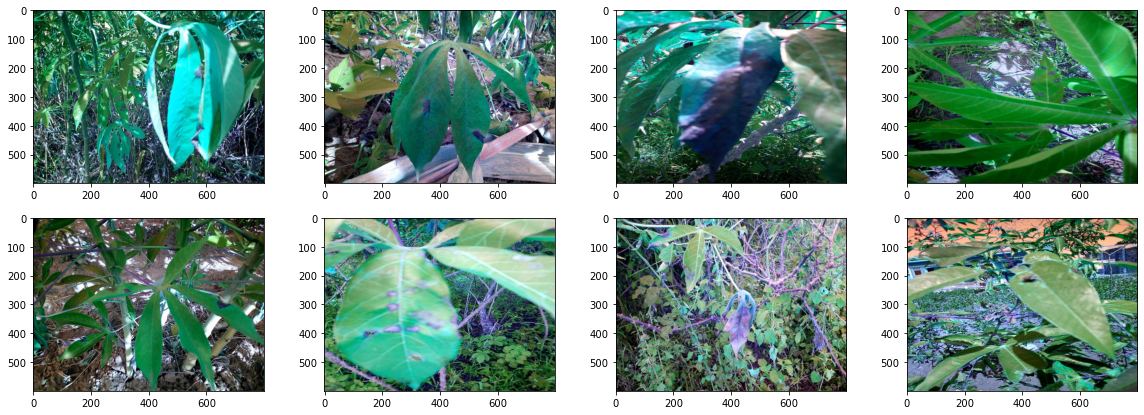

In [22]:
plot_samples(0)

**Symptoms**

Small, angular, brown, water-soaked lesions between leaf veins on lower surfaces of leaves; leaf blades turning brown as lesion expands; lesions may have a yello halo; lesions coalesce to form large necrotic patches; defoliation occurs with leaf petioles remaining in horizontal position as leaves drop; dieback of shoots; brown gum may be present on stems, leaves and petioles

**Cause**

Bacterium


Some Sample Images belonging to Class CBSD


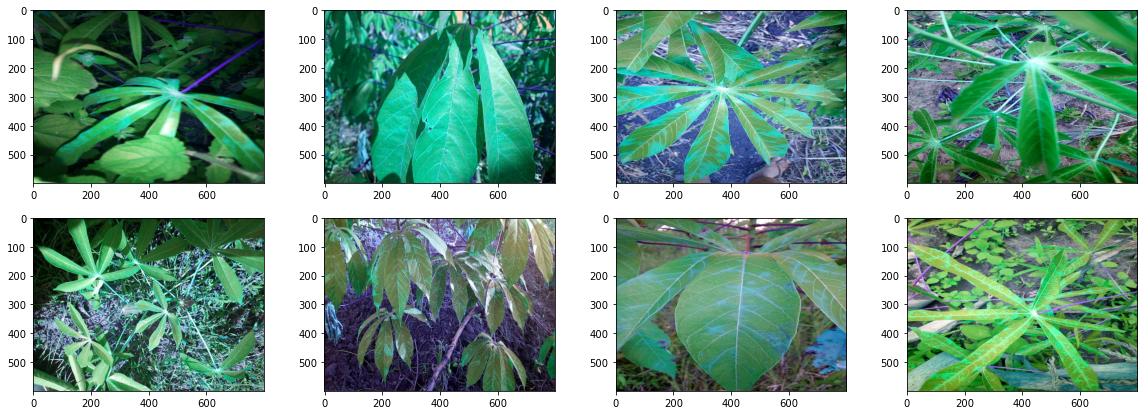

In [28]:
plot_samples(1)

**Symptoms**  
Leaves: 
- chlorotic or necrotic vein banding in mature leaves which may merge later to form large yellow patches

Stems:

- Brown elongated necrotic lesions on young stems

**Cause**

Virus

Some Sample Images belonging to Class CGM


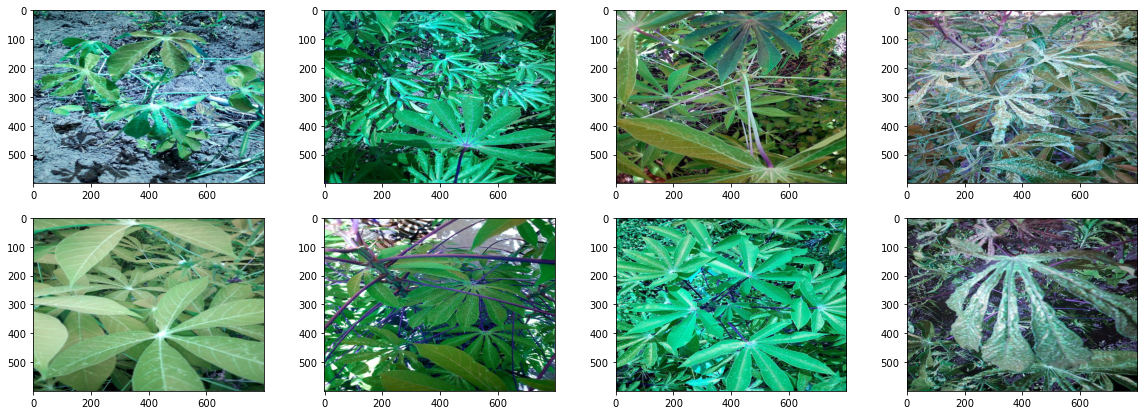

In [29]:
plot_samples(2)

**Symptoms**

Young leaves are puckered with faint to distinct yellow spots (Photo 1), green patterns (mosaics), and twisted margins (Photo 2). Usually, the shoots recover from symptoms and appear healthy. Occasionally, plants become severely stunted, edible roots are absent or, if present, they are small and woody when cooked.

**Cause**  
Virus

Some Sample Images belonging to Class CMD


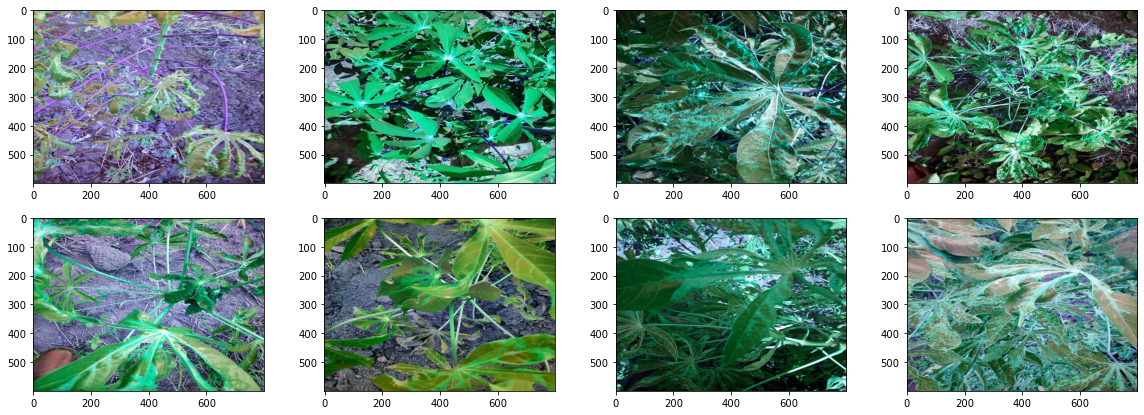

In [30]:
plot_samples(3)

**Symptoms**  
Discolored pale green, yellow or white mottled leaves which may be distorted with a reduced size; in highly susceptible cassava cultivars plant growth may be stunted, resulting in poor root yield and low quality stem cuttings. Note that infected plants can express a range of symptoms and the exact symptoms depend on the species of virus and the strain as well as the environmental conditions and and the sensitivity of the cassava host.

1. Patches of discolouration (chlorosis) in the leaves that vary from yellow to green.
2. The leaves display size variation and are often severely distorted.
3. Leaf blades sometimes fold depending on severity shrivel.

**Cause**
Virus

Some Sample Images belonging to Class Healthy


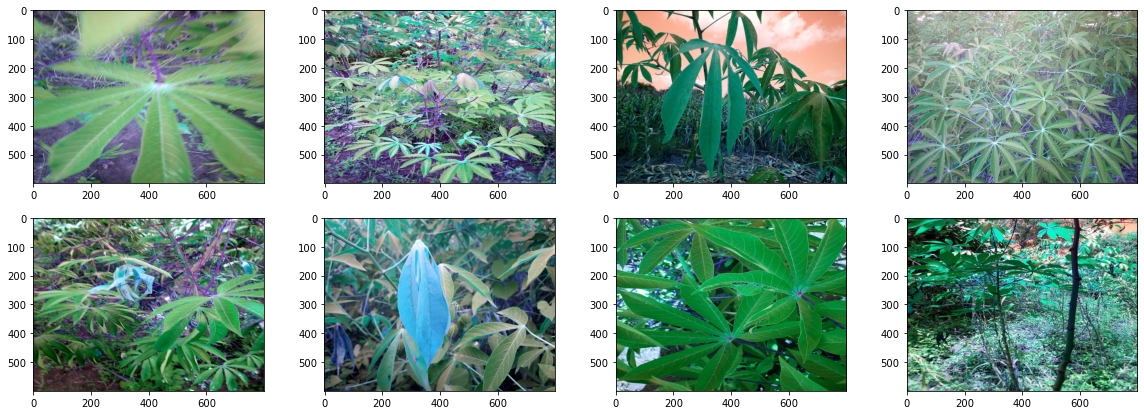

In [31]:
plot_samples(4)

 The leaves are palmate (hand-shaped) and dark green in color. The cone-shaped roots are starch storage organs covered with a papery bark and a pink to white cortex. The flesh ranges from bright white to soft yellow. Over five thousand varieties of cassava are known, each of which has its own distinctive qualities and is adapted to different environmental conditions.

### Model Training

#### Parameters

In [ ]:
BATCH_SIZE = 8
image_size = 512
input_shape = (image_size, image_size, 3)
dropout_rate = 0.4
classes_to_predict = 5
EPOCHS = 8

#### Augmentation Layers

In [ ]:
data_augmentation_layers = tf.keras.Sequential(
    [layers.experimental.preprocessing.RandomCrop(height=image_size, 
                                                  width=image_size),
     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
     layers.experimental.preprocessing.RandomRotation(0.25),
     layers.experimental.preprocessing.RandomZoom((-0.2, 0)),
     layers.experimental.preprocessing.RandomContrast((0.2,0.2))]
)

#### Custom Loss Function (SCCE with Label Smoothing)

In [ ]:
def scce_with_ls(y, y_hat):
    """
    Custom loss function to apply label smoothing on Sparse Categorical 
    Crossentropy.
    """
    
    y = tf.one_hot(tf.cast(y, tf.int32), 5)
    y = tf.squeeze(y, axis=1)
    return categorical_crossentropy(y, y_hat, label_smoothing=0.3)

LOSS = scce_with_ls

#### Model Setup and Helper Functions

In [10]:
def create_model():
    """
    Creates a Convolutional Neural Network:
    - Preprocessing: Image Augmentation
    - Backbone: EfficientNetB3
    - Neck: Global Average Pooling, Dropout
    - Head: Dense, 5 classes
    - Optimizer: Adam
    - LR Scheduler: Cosine Decay, initial LR = 1e-4
    """
    
    conv_base = EfficientNetB3(weights='imagenet',
                      include_top=False,
                      input_shape=(input_shape)
                     )

    inputs = Input(shape=input_shape)
    augmented = data_augmentation_layers(inputs)
    conv_base = conv_base(augmented)
    pooling = layers.GlobalAveragePooling2D()(conv_base)
    dropout = layers.Dropout(dropout_rate)(pooling)
    outputs = Dense(classes_to_predict, activation="softmax")(dropout)
    model = Model(inputs=inputs, outputs=outputs)

    decay_steps = int(round(len(df)*0.8)/BATCH_SIZE)*EPOCHS
    cosine_decay = CosineDecay(initial_learning_rate=1e-4,
                               decay_steps=decay_steps, alpha=0.3)

    model.compile(loss=LOSS,
                  optimizer=tf.keras.optimizers.Adam(cosine_decay), 
                  metrics=["accuracy"])
    
    return model

In [11]:
def load_image_and_label_from_path(image_path, label):
    """
    Function to map in dataframe. 
    Returns decoded image with 3 channels and its label.
    """
    
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img, label

In [12]:
def train_cross_validate(folds=5):
    """
    Accepts the number of folds, trains the CNN, and returns the history and
    model. Best model for each fold is saved as an h5 file.
    """
    
    histories = []
    models = []
    
    kfold = KFold(folds, shuffle=True, random_state=42)
    
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(df)):
        
        # Free up Memory
        gc.collect()
        K.clear_session()
        
        print(f'Fold: {fold}')
        
        # Load datasets
        training_df = df.loc[trn_ind]
        validation_df = df.loc[val_ind]
       
        training_data = tf.data.Dataset.from_tensor_slices(
            (training_df.filepath.values, training_df.label.values))
        validation_data = tf.data.Dataset.from_tensor_slices(
            (validation_df.filepath.values, validation_df.label.values))
        
        AUTOTUNE = tf.data.experimental.AUTOTUNE
        
        training_data = training_data.map(
            load_image_and_label_from_path, num_parallel_calls=AUTOTUNE)
        validation_data = validation_data.map(
            load_image_and_label_from_path, num_parallel_calls=AUTOTUNE)
        
        training_data_batches = (training_data
                                 .shuffle(buffer_size=1000)
                                 .batch(BATCH_SIZE)
                                 .prefetch(buffer_size=AUTOTUNE))
        validation_data_batches = (validation_data
                                   .shuffle(buffer_size=1000)
                                   .batch(BATCH_SIZE)
                                   .prefetch(buffer_size=AUTOTUNE))
        
        # Setup Callbacks to save best model
        checkpoint_name = 'efficientnetb3-CV-ls_0.3_'+str(fold)+'.h5'        
        callbacks = [ModelCheckpoint(
            filepath=checkpoint_name, 
            monitor='val_loss', 
            save_best_only=True)]
        
        # Create model and start training
        model = create_model()      
        history = model.fit(training_data_batches,
                            epochs = EPOCHS, 
                            validation_data=validation_data_batches,
                            callbacks=callbacks, 
                            batch_size=BATCH_SIZE)
        print('Load best weights for model prediction')
        model.load_weights(checkpoint_name)
        models.append(model)
        histories.append(history)

    return histories, models

#### Model Training (5 folds)

In [13]:
histories, models = train_cross_validate()

Fold: 0
Epoch 1/8
2140/2140 [==============================] - 1274s 586ms/step - loss: 1.2079 - accuracy: 0.7335 - val_loss: 1.0535 - val_accuracy: 0.8692
Epoch 2/8
2140/2140 [==============================] - 1253s 584ms/step - loss: 1.0818 - accuracy: 0.8475 - val_loss: 1.0514 - val_accuracy: 0.8715
Epoch 3/8
2140/2140 [==============================] - 1252s 584ms/step - loss: 1.0575 - accuracy: 0.8696 - val_loss: 1.0635 - val_accuracy: 0.8598
Epoch 4/8
2140/2140 [==============================] - 1257s 586ms/step - loss: 1.0433 - accuracy: 0.8785 - val_loss: 1.0328 - val_accuracy: 0.8841
Epoch 5/8
2140/2140 [==============================] - 1253s 584ms/step - loss: 1.0304 - accuracy: 0.8864 - val_loss: 1.0254 - val_accuracy: 0.8857
Epoch 6/8
2140/2140 [==============================] - 1256s 586ms/step - loss: 1.0190 - accuracy: 0.8993 - val_loss: 1.0331 - val_accuracy: 0.8820
Epoch 7/8
2140/2140 [==============================] - 1257s 586ms/step - loss: 1.0104 - accuracy: 0.900